In [1]:
# Import libraries and data
import os
import numpy as np
import pickle

from src.utils.linear_regressor import perform_linear_regression
from config.settings import ROOT_DIR, saved_models_path
from src.utils.evaluate import evaluate
from src.utils.column_import import columns
s_x, s_y, v_x, v_y, a_x, a_y = columns


/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/inD/x_y_recording_00_range_384.csv
/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/scenario_samples/lane_merging/dif_set/test_set_00.csv


# Acceleration Model (4 params)

In [50]:

s_x, s_y, v_x, v_y, a_x, a_y

(array([ 0.     , -0.04689, -0.09698, ..., 17.46545, 18.01444, 18.56397]),
 array([ 0.     , -0.35613, -0.71906, ..., 10.2941 , 10.61179, 10.92948]),
 array([-1.20819, -1.20844, -1.20806, ..., 13.73744, 13.7408 , 13.74424]),
 array([-9.06651, -9.06017, -9.05198, ...,  7.95971,  7.95183,  7.94404]),
 array([-0.01047, -0.01211, -0.01427, ...,  0.08581,  0.08579,  0.08579]),
 array([ 0.52307,  0.5597 ,  0.61071, ..., -0.19465, -0.19468, -0.19468]))

In [85]:
v_x_1 = v_x[1]
v_y_1 = v_y[1]
v_x_2 = v_x[2]
v_y_2 = v_y[2]
a_x_1 = a_x[1]
a_y_1 = a_y[1]
a_x_0 = a_x[0]
a_y_0 = a_y[0]
# Print stored values
print("v_x_1:", v_x_1)
print("v_y_1:", v_y_1)
print("v_x_2:", v_x_2)
print("v_y_2:", v_y_2)
print("a_x_1:", a_x_1)
print("a_y_1:", a_y_1)
print("a_x_0:", a_x_0)
print("a_y_0:", a_y_0)

c_1_dash = np.float64(- 0.9952528070987241)
c_2_dash = np.float64(-7.660306449080449e-05)

#c_1_dash =1. 
#c_2_dash =1. 


a_y_0_test = - c_1_dash * a_y_1 + c_2_dash * (v_y_2 - v_y_1)


print(f"Expected: {a_y_0}")
print(f'Result:   {a_y_0_test}')


c_2 = 1./c_2_dash
c_1 = c_1_dash * c_2

v_y_2_test = c_1* a_y_0_test + c_2* a_y_1 +  v_y_1

print(f"Expected: {v_y_2}")
print(f'Result:   {v_y_2_test}')




v_x_1: -1.20844
v_y_1: -9.06017
v_x_2: -1.20806
v_y_2: -9.05198
a_x_1: -0.01211
a_y_1: 0.5597
a_x_0: -0.01047
a_y_0: 0.52307
Expected: 0.52307
Result:   0.5570423687540577
-0.9952528070987241
-7.660306449080449e-05
12992.336712824266
-13054.308031241244
Expected: -9.05198
Result:   -78.27435692378756



Acceleration model with 4 parameters
\begin{align}
a(k-1) &= - \overline c_1 a(k)  + \overline c_2 \bigl( v(k+1) - v(k) \bigr) \\
a(k-1) &= - \overline c_3 a(k)  + \overline c_4 \bigl( s(k+1) - s(k) - dt \  v(k)\bigr)
\end{align}

Model in matrix notation
\begin{align}
    \begin{bmatrix}
        a(k-1) \\ a(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
         -a(k)  & v(k+1) - v(k)  & 0 & 0 \\
         0 & 0 & -a(k) &    s(k+1) - s(k) - dt \  v(k)
        \end{bmatrix}
        \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
    \end{bmatrix}
\end{align}

Add x and y components

\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_x(k-1) \\ 
        a_y(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k+1) - v_x(k)  & 0 & 0                   \\ 
        0 & 0 & -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k)  & v_y(k+1) - v_y(k)  & 0 & 0                   \\
        0 & 0 & -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}

For easier implementation split into two models

First model
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1) \\ 
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k+1) - v_x(k)   \\ 
        -a_y(k)  & v_y(k+1) - v_y(k)   \\
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
   \end{bmatrix}
\end{align}



Second model
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_3 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}



## Matrix creation
and same model 
but relative speed, position and acceleration

In [77]:
# Index shifting:
# k-1         k           k+1
# 0:-2         1:-1        2:

In [78]:
# Target vector y
y = np.concatenate([a_x[0:-2], a_y[0:-2]])    # a(k)
y.shape


(410546,)

In [79]:
# Input features X_a of the first model
A = - a_x[1:-1]                
B = - a_y[1:-1]                
C = v_x[2:] - v_x[1:-1]        
D = v_y[2:] - v_y[1:-1]        

X_a = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
    ))
X_a.shape


(410546, 2)

Mean Squared Error (MSE): 3.0955e-03
Mean Absolute Error (MAE): 1.1690e-02
R-squared (R²) Score: 9.9060e-01
Coefficients:
-0.9952445671614876
-7.628629025987907e-05


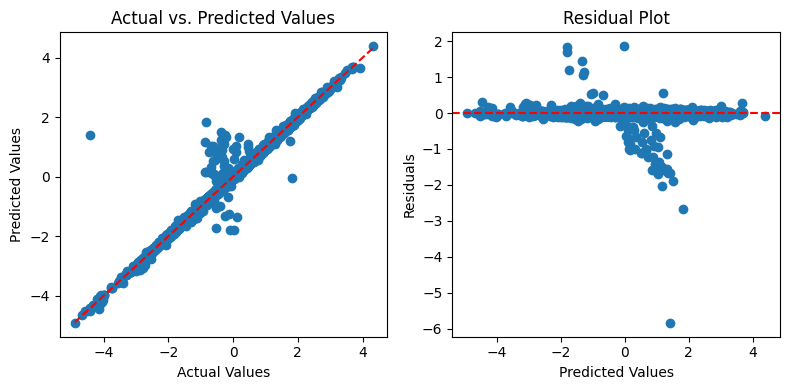

In [80]:
# Input features X_b of the second model

y = np.concatenate([a_x[0:-2], a_y[0:-2]])    # a(k)
dt = 0.04
A = - a_x[1:-1]                                 
B = - a_y[1:-1]                                 
C = s_x[2:] - s_x[1:-1] - dt * v_x[1:-1]        
D = s_y[2:] - s_y[1:-1] - dt * v_y[1:-1]        

X_b = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
    ))
X_b.shape

# First model
first_model = perform_linear_regression(X_a, y)



## Perform Regression

Mean Squared Error (MSE): 3.0955e-03
Mean Absolute Error (MAE): 1.1690e-02
R-squared (R²) Score: 9.9060e-01
Coefficients:
-0.9952445671614876
-7.628629025987907e-05


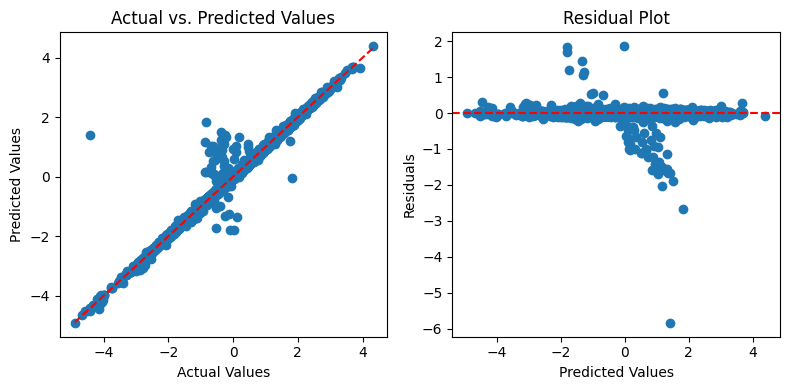

In [81]:
# First model
first_model = perform_linear_regression(X_a, y)


Mean Squared Error (MSE): 3.0955e-03
Mean Absolute Error (MAE): 1.1690e-02
R-squared (R²) Score: 9.9060e-01
Coefficients:
-0.9952416326195912
1.5983549942566857e-06


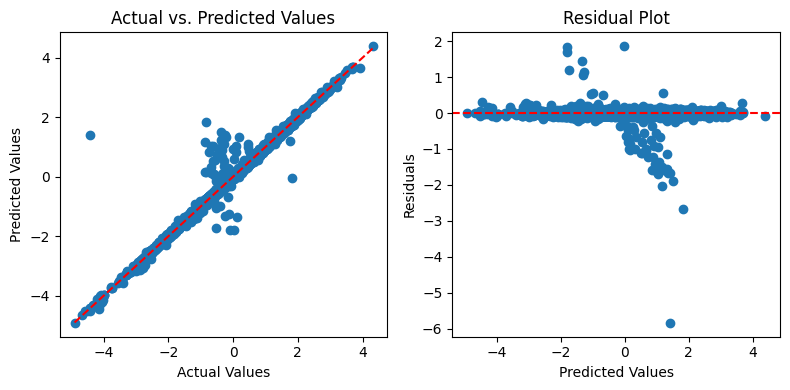

In [83]:
# Second model
second_model = perform_linear_regression(X_b, y)

In [84]:
# Save both models in a pickle file
def save_model(model, model_name):
    model_file_path = os.path.join(saved_models_path, f'acceleration_model_4/{model_name}.pkl')
    
    with open(model_file_path, 'wb') as file:
        pickle.dump(model, file)
    
    print(f'Model "{model_name}" saved to: {model_file_path}')

save_model(first_model, 'first_model')
save_model(second_model, 'second_model')

Model "first_model" saved to: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/acceleration_model_4/first_model.pkl
Model "second_model" saved to: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/acceleration_model_4/second_model.pkl


In [63]:
second_model.coef_[1].dtype

dtype('float64')